### How online and offline averaging differ for fluxes and flux div?

The temperature equation is: 
$$
\partial_t T + \mathbf{u} \cdot \nabla  T  = 0
$$

The goal of this work is to look at this equation under the lens of a filter, in particular we will do long time average combined with some spatial average. 

Under such an average we get 
$$
\partial_t \overline{T} + \overline{\mathbf{u} \cdot \nabla  T}  = 0
$$
where the second term on the LHS can be written as  (same for T or any tracer C)
\begin{equation} 
\overline{ \nabla \cdot \mathbf{u} C } = \nabla \cdot \overline{  \mathbf{u} C } = \nabla \cdot \overline{  \mathbf{u}} \overline{C}   +  [\nabla \cdot \overline{  \mathbf{u} C } - \nabla \cdot \overline{  \mathbf{u}} \overline{C}]
\end{equation}

where at the end we did a decompsition into mean and eddy fluxes. If the filters are Reynold's operators, then that term simply reduces to $ \nabla \cdot \overline{  \mathbf{u}' C' }$.

The trick to all this is that if we are doing time averages as part of the filter, then ideally we need to have online averages (or data output for every time step). However, that is prohibitively expensive, so we output the data every 3 days here. This is definitely not sufficient to close a heat budget because those small differences start to matter when we take long averages that are meant to go to zero. 
In particular in the adiabatic interior the time tendency becomes smaller and smaller with longer time averaging, which would require the 2nd term on the LHS to also go to zero. However, when do these long averages online vs offline, things don't match up. 

**Having said that, all this likely not that important for what we are going to be doing here. Our goal is to represent the eddy fluxes using a reduced model (transport tensor). This model will not be able to capture the flux (or its divergence) correctly upto 0% error, so the small error we make due to not using online averages is likely completely swarmed by the accuracy of the reduced model (or due to regularization).**

In [1]:
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
import numpy as np
from xgcm import Grid
import xrft

%matplotlib inline

In [2]:
# Load snapshot data
ds_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored/'
ds_snap = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')

In [3]:
# Load time average data
data_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored/'

model_vars = ['uVeltave','vVeltave','wVeltave', 'Ttave', 
             'UTtave', 'VTtave','WTtave','UUtave', 'UVtave', 'VVtave', 'TTtave', 'ETAtave']
ds_model = open_mdsdataset(data_dir , delta_t=300,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

model_vars = ['tracer1_diag', 'tracer2_diag', 'tracer3_diag', 'tracer4_diag', 'tracer5_diag',
              'tracer6_diag', 'tracer7_diag', 'tracer8_diag', 'tracer9_diag', 'tracer10_diag',
              'tracer11_diag', 'tracer12_diag', 'tracer13_diag', 'tracer14_diag', 'tracer15_diag',
              'tracer16_diag', 'tracer17_diag', 'tracer18_diag', 'tracer19_diag', 'tracer20_diag',]
ds_tracers = open_mdsdataset(data_dir , delta_t=300,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

ds_tav = xr.merge([ds_model, ds_tracers])
ds_tav = ds_tav.isel(time=slice(78,110)) # select only last 20 year data

### Impact of time filter on spatial scales

In [4]:
Tsnap_mean = ds_snap['T'].mean('time')
Csnap_mean = ds_snap['PTRACER01'].mean('time')
Tsnap_mean.load();
Csnap_mean.load();

In [5]:
Ttave_mean = ds_tav['Ttave'].mean('time')
Ctave_mean = ds_tav['TRAC01'].mean('time')
Ttave_mean.load();
Ctave_mean.load();

The 2 avg will not agree in point wise sense because they are over different periods. 

In [6]:
T_ps_x = xrft.power_spectrum(ds_snap['T'].drop(['Depth', 'hFacC', 'maskC', 'rA']), dim=['XC']).rename('T_ps')
C_ps_x = xrft.power_spectrum(ds_snap['PTRACER01'].drop(['Depth', 'hFacC', 'maskC', 'rA']), dim=['XC']).rename('C_ps')

Tsnap_mean_ps_x = xrft.power_spectrum(Tsnap_mean.drop(['Depth', 'hFacC', 'maskC', 'rA']), dim=['XC']).rename('T_ps')
Csnap_mean_ps_x = xrft.power_spectrum(Csnap_mean.drop(['Depth', 'hFacC', 'maskC', 'rA']), dim=['XC']).rename('C_ps')

Ttave_mean_ps_x = xrft.power_spectrum(Ttave_mean.drop(['Depth', 'hFacC', 'maskC', 'rA']), dim=['XC']).rename('T_ps')
Ctave_mean_ps_x = xrft.power_spectrum(Ctave_mean.drop(['Depth', 'hFacC', 'maskC', 'rA']), dim=['XC']).rename('C_ps')

Text(0.5, 0, 'k [1/m]')

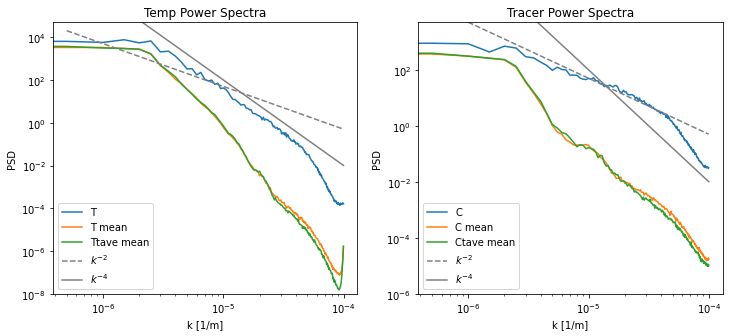

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
T_ps_x.isel(time=0).sel(Z=-1000, method='nearest'
                       ).sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='T')
Tsnap_mean_ps_x.sel(Z=-1000, method='nearest'
                       ).sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='T mean')
Ttave_mean_ps_x.sel(Z=-1000, method='nearest'
                       ).sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='Ttave mean')

k= T_ps_x.freq_XC

plt.plot(k, 5e-9*k**-2, '--', color='gray', label=r'$k^{-2}$')
plt.plot(k, 1e-18*k**-4, '-', color='gray', label=r'$k^{-4}$')

plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-8, 5e4])
plt.legend()

plt.title('Temp Power Spectra')
plt.ylabel('PSD')
plt.xlabel('k [1/m]')

plt.subplot(122)
C_ps_x.isel(time=0).sel(Z=-1000, method='nearest'
                       ).sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='C')
Csnap_mean_ps_x.sel(Z=-1000, method='nearest'
                       ).sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='C mean')
Ctave_mean_ps_x.sel(Z=-1000, method='nearest'
                       ).sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='Ctave mean')


k= T_ps_x.freq_XC

plt.plot(k, 5e-9*k**-2, '--', color='gray', label=r'$k^{-2}$')
plt.plot(k, 1e-18*k**-4, '-', color='gray', label=r'$k^{-4}$')

plt.xscale('log')
plt.yscale('log')

plt.ylim([1e-6, 5e3])
plt.legend()

plt.title('Tracer Power Spectra')
plt.ylabel('PSD')
plt.xlabel('k [1/m]')

Notice above that the online averages are slightly smoother than the offline averages, at smaller scales. 

### Impact of time average on time tendency 

In [9]:
# convert type for time (this annoying)
time_snap = ((ds_snap.time - ds_snap.time[0])/1e9/3600/24).astype('float')
time_tav = ((ds_tav.time - ds_tav.time[0])/1e9/3600/24).astype('float')

In [13]:
Tsnap_tend = ds_snap['T'].diff('time')/ time_snap.diff('time')
Ttav_tend = ds_tav['Ttave'].diff('time')/ time_tav.diff('time')

In [26]:
# how does this quantity decrease with increasing filter scale
Tsnap_tend_Tscale = Tsnap_tend.cumsum('time')*3. / time_snap[1:-1]
Ttav_tend_Tscale  = Ttav_tend.cumsum('time')*180. / time_tav[1:-1]

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Text(0, 0.5, '')

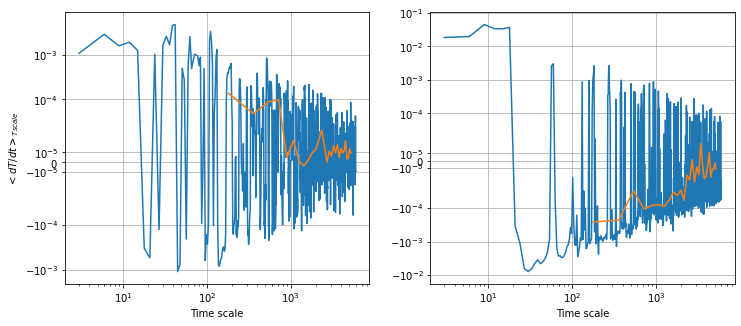

In [36]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(time_snap[1:-1],  
         Tsnap_tend_Tscale.sel(XC=0., YC=1000e3 , Z=-1000, method='nearest') )

plt.plot(time_tav[1:-1],  
         Ttav_tend_Tscale.sel(XC=0., YC=1000e3 , Z=-1000, method='nearest') )
plt.yscale('symlog', linthresh=5e-5)
plt.xscale('log')

plt.grid()

plt.xlabel('Time scale')
plt.ylabel(r'$<dT/dt>_{Tscale}$')

plt.subplot(122)
plt.plot(time_snap[1:-1],  
         Tsnap_tend_Tscale.sel(XC=1500e3, YC=1000e3 , Z=-1000, method='nearest') )

plt.plot(time_tav[1:-1],  
         Ttav_tend_Tscale.sel(XC=1500e3, YC=1000e3 , Z=-1000, method='nearest') )
plt.yscale('symlog', linthresh=5e-5)
plt.xscale('log')

plt.grid()

plt.xlabel('Time scale')
plt.ylabel('')

Note that the above plot is not quite an integral of the of the time tendency (but rather of tendency of means), so it is not necessarily a very useful metric. 

### Impact of time average on fluxes 

How quickly do the eddy fluxes converge with time averaging? 

In [39]:
import sys
sys.path.append('../../m2lines/channel-coarse-grain-pipeline/modules/')
import MITgcm_advection_schemes as MAS

In [72]:
# Snapshot data 

# Snap shot vels to flux div
Tsnap_flux = MAS.advection_scheme2(ds_snap, flux_var='T')
Tsnap_flux['Fdiv'] = MAS.flux_div(Tsnap_flux)

grid = Grid(ds_snap, periodic='X')

# Mean flux
Tsnap_flux['Fx_mean'] = ds_snap.U.mean('time') *grid.interp(Tsnap_mean, 'X') * ds_snap.dyG * ds_snap.drF * ds_snap.hFacW
Tsnap_flux['Fy_mean'] = ds_snap.V.mean('time') *grid.interp(Tsnap_mean, 'Y', boundary='extend') * ds_snap.dxG * ds_snap.drF * ds_snap.hFacS
Tsnap_flux['Fz_mean'] = ds_snap.W.mean('time') *grid.interp(Tsnap_mean, 'Z', boundary='extend') * ds_snap.rA 
Tsnap_flux['Fdiv_mean'] = MAS.flux_div(Tsnap_flux, flux_vars = ['Fx_mean', 'Fy_mean', 'Fz_mean'] )

# Eddy flux
Tsnap_flux['Fdiv_eddy'] = Tsnap_flux['Fdiv'] -  Tsnap_flux['Fdiv_mean']

In [71]:
# Time avg data 

Ttave_flux = xr.Dataset()

Ttave_flux['Fx'] = ds_tav.UTtave * ds_tav.dyG * ds_tav.drF * ds_tav.hFacW
Ttave_flux['Fy'] = ds_tav.VTtave * ds_tav.dxG * ds_tav.drF * ds_tav.hFacS
Ttave_flux['Fz'] = ds_tav.WTtave * ds_tav.rA 

Ttave_flux = Ttave_flux.assign_coords(ds_tav.coords)
Ttave_flux['Fdiv'] = MAS.flux_div(Ttave_flux)

Ttave_flux['Fx_mean'] = ds_tav.uVeltave.mean('time') *grid.interp(ds_tav.Ttave.mean('time'), 'X') * ds_tav.dyG * ds_tav.drF * ds_tav.hFacW
Ttave_flux['Fy_mean'] = ds_tav.vVeltave.mean('time') *grid.interp(ds_tav.Ttave.mean('time'), 'Y', boundary='extend') * ds_tav.dxG * ds_tav.drF * ds_tav.hFacS
Ttave_flux['Fz_mean'] = ds_tav.wVeltave.mean('time') *grid.interp(ds_tav.Ttave.mean('time'), 'Z', boundary='extend') * ds_tav.rA 
Ttave_flux['Fdiv_mean'] = MAS.flux_div(Ttave_flux, flux_vars = ['Fx_mean', 'Fy_mean', 'Fz_mean'] )

Ttave_flux['Fdiv_eddy'] = Ttave_flux['Fdiv'] - Ttave_flux['Fdiv_mean'] 

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


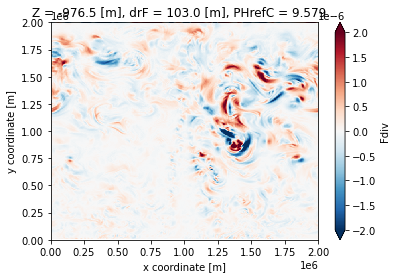

In [50]:
Tsnap_flux['Fdiv'].isel(time=0).sel(Z=-1000, method='nearest').plot(vmin=-2e-6)

In [52]:
Fdiv_snap_mean = Tsnap_flux['Fdiv'].sel(Z=-1000, method='nearest').mean('time')
Fdiv_snap_mean.load();

Fdiv_tave_mean = Ttave_flux['Fdiv'].sel(Z=-1000, method='nearest').mean('time')
Fdiv_tave_mean.load();

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


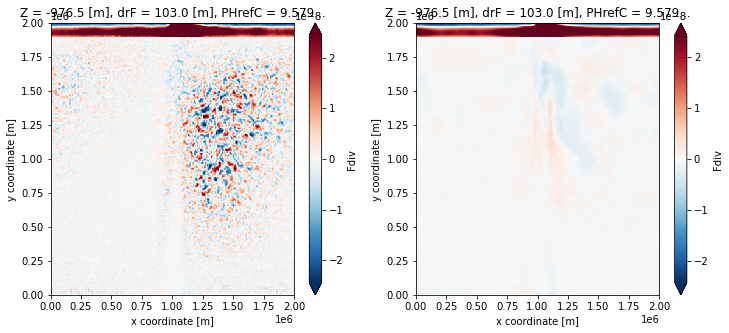

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
Fdiv_snap_mean.plot(robust=True)

plt.subplot(122)
Fdiv_tave_mean.plot(robust=True)

In [55]:
Fdiv_mean_snap_mean = Tsnap_flux['Fdiv_mean'].sel(Z=-1000, method='nearest')
Fdiv_mean_snap_mean.load();

Fdiv_mean_tave_mean = Ttave_flux['Fdiv_mean'].sel(Z=-1000, method='nearest')
Fdiv_mean_tave_mean.load();

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


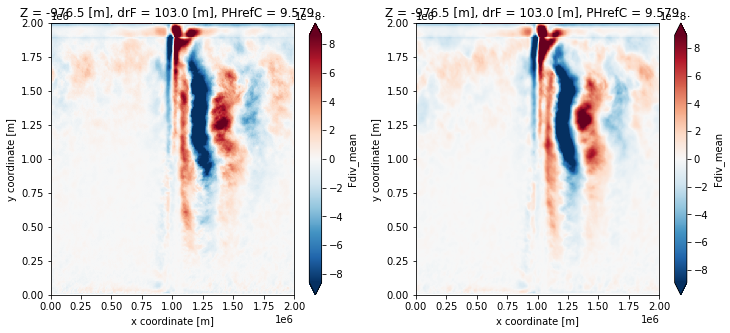

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
Fdiv_mean_snap_mean.plot(robust=True)

plt.subplot(122)
Fdiv_mean_tave_mean.plot(robust=True)

In [58]:
Fdiv_mean_snap_ps_x = xrft.power_spectrum(Fdiv_mean_snap_mean.drop(['Depth', 'hFacC', 'maskC', 'rA'])
                                          ,  dim=['XC']).rename('Fdiv_ps')
Fdiv_mean_tav_ps_x = xrft.power_spectrum(Fdiv_mean_tave_mean.drop(['Depth', 'hFacC', 'maskC', 'rA']) 
                                         ,  dim=['XC']).rename('Fdiv_ps')

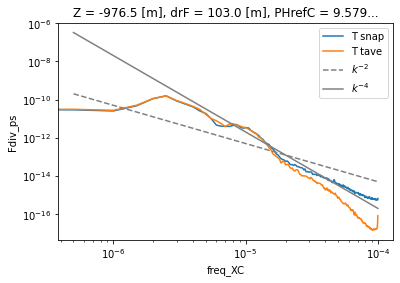

In [65]:
Fdiv_mean_snap_ps_x.sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='T snap')
Fdiv_mean_tav_ps_x.sel(YC=slice(100e3, 1900e3)).mean('YC').plot(label='T tave')

k= T_ps_x.freq_XC

plt.plot(k, 5e-23*k**-2, '--', color='gray', label=r'$k^{-2}$')
plt.plot(k, 2e-32*k**-4, '-', color='gray', label=r'$k^{-4}$')

plt.xscale('log')
plt.yscale('log')

#plt.ylim([1e-8, 5e4])
plt.legend()

Snap shot and time average mean (and eddy will be the same) flux divergeences diverge around scales smaller than 100km. We will filter below that going forward. 

In [68]:
Tsnap_Fdiv_Tscale = Tsnap_flux['Fdiv'].cumsum('time')*3. / time_snap[1:-1]
Ttave_Fdiv_Tscale = Ttave_flux['Fdiv'].cumsum('time')*180. / time_tav[1:-1]

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [73]:
Tsnap_Fdiv_eddy_Tscale = Tsnap_flux['Fdiv_eddy'].cumsum('time')*3. / time_snap[1:-1]
Ttave_Fdiv_eddy_Tscale = Ttave_flux['Fdiv_eddy'].cumsum('time')*180. / time_tav[1:-1]

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0, 0.5, '')

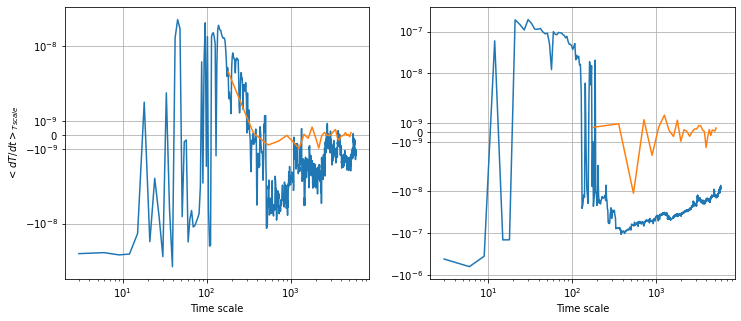

In [70]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(time_snap[1:-1],  
         Tsnap_Fdiv_Tscale.sel(XC=0., YC=1000e3 , Z=-1000, method='nearest') )

plt.plot(time_tav[1:-1],  
         Ttave_Fdiv_Tscale.sel(XC=0., YC=1000e3 , Z=-1000, method='nearest') )
plt.yscale('symlog', linthresh=5e-9)
plt.xscale('log')

plt.grid()

plt.xlabel('Time scale')
plt.ylabel(r'$<dT/dt>_{Tscale}$')

plt.subplot(122)
plt.plot(time_snap[1:-1],  
         Tsnap_Fdiv_Tscale.sel(XC=1500e3, YC=1000e3 , Z=-1000, method='nearest') )

plt.plot(time_tav[1:-1],  
         Ttave_Fdiv_Tscale.sel(XC=1500e3, YC=1000e3 , Z=-1000, method='nearest') )
plt.yscale('symlog', linthresh=5e-9)
plt.xscale('log')

plt.grid()

plt.xlabel('Time scale')
plt.ylabel('')

This above plots shows sort of what we had expected (as also seen in the earlier plot). Essentially the online time average converges rapidly, while the snapshot time average does not (this quantity is quite small).
However, one interesting thing is that it take about 1-2 years for the flux divergence to converge. 
Note that the snapshot flux divergence does not even converge after 15 years!! 

In contrast the eddy flux divergence (this term is not becoming small) converges faster. 

/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/dbalwada/.conda/envs/GM-Redi-offline-env/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0, 0.5, '')

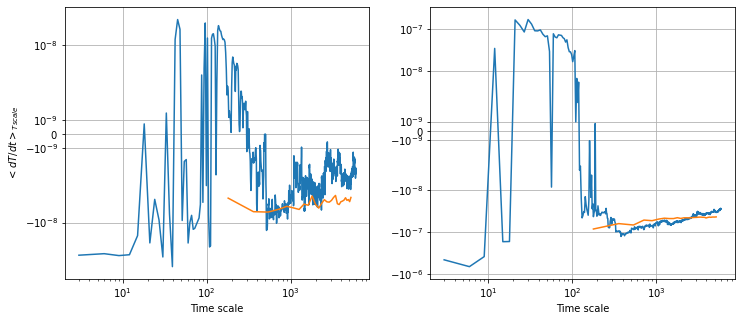

In [74]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(time_snap[1:-1],  
         Tsnap_Fdiv_eddy_Tscale.sel(XC=0., YC=1000e3 , Z=-1000, method='nearest') )

plt.plot(time_tav[1:-1],  
         Ttave_Fdiv_eddy_Tscale.sel(XC=0., YC=1000e3 , Z=-1000, method='nearest') )
plt.yscale('symlog', linthresh=5e-9)
plt.xscale('log')

plt.grid()

plt.xlabel('Time scale')
plt.ylabel(r'$<dT/dt>_{Tscale}$')

plt.subplot(122)
plt.plot(time_snap[1:-1],  
         Tsnap_Fdiv_eddy_Tscale.sel(XC=1500e3, YC=1000e3 , Z=-1000, method='nearest') )

plt.plot(time_tav[1:-1],  
         Ttave_Fdiv_eddy_Tscale.sel(XC=1500e3, YC=1000e3 , Z=-1000, method='nearest') )
plt.yscale('symlog', linthresh=5e-9)
plt.xscale('log')

plt.grid()

plt.xlabel('Time scale')
plt.ylabel('')

Some of the differences we see b/w the snapshot and tav here is likely due to location differences. 